In [1]:
from IPython.display import display

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score, plot_confusion_matrix

import category_encoders as ce

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from utils import load_dataset, clean_dataset
from bias_utils import df_to_aequitas,fairness_report,aequitas_preprocessing

In [2]:
df = load_dataset()
df = clean_dataset(df)

In [3]:
display(df.head(3))
display(df.shape)

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
71,True,False,Bridgeport,2013-10-01 00:46:00,bridgeport,V,1207,True,I,Speed Related,37.0,H,W,M,True
143,True,True,Milford,2013-10-01 01:50:00,milford,E,2325,True,I,Defective Lights,30.0,N,W,M,True
184,True,False,Torrington,2013-10-01 03:49:00,torrington,V,DACYR048,True,C,Registration,43.0,N,W,M,True


(76743, 15)

# Pipeline

## Classes

In [4]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    

class CategorySelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on category columns in the data
    """
    def transform(self, X):
        return X[self.key]
    
class TimeSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    a datetime column
    """
    def transform(self, X):
        return X[self.key]

class ExtractTimeFeatures(TransformerMixin):
    """
    Transformer to process datetime column.
    """
    def transform(self, X, *_):
        _X = pd.DataFrame(data=X.values,index=X.index,columns=['time'])
        _X['hour'] = _X.time.dt.hour
        return _X[['hour']]
    
    def fit(self, *_):
        return self

## Code

In [5]:
category = Pipeline([
                ('selector', CategorySelector(["InterventionReasonCode","SearchAuthorizationCode"])),
                ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='indicator'))
            ])
time = Pipeline([
                ('selector', TimeSelector("InterventionDateTime")),
                ('featureExtraction', ExtractTimeFeatures())
])
department = Pipeline([
                ('selector', CategorySelector('InterventionLocationName')),
                ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='indicator'))
])

feats = FeatureUnion([('categories', category), 
                      ('time', time),
                      ('department', department)])

pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


pipeline.fit(train_data, train_data.ContrabandIndicator)

preds = pipeline.predict(test_data)


/home/simaonovais/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [6]:
def create_predictions_dataframe(df: pd.DataFrame, preds: np.array)->pd.DataFrame:
    """
    Creates predictions dataframe with original features and a new column "Predictions"
    that replaces the "VehicleSearchedIndicator" column with the model predictions.
    """
    _df = df.copy()
    predictions_df = _df.copy()
    predictions_df = predictions_df.drop(columns=['VehicleSearchedIndicator'])
    columns = list(predictions_df.columns)
    predictions_df = predictions_df.assign(Prediction=preds)
    predictions_df = predictions_df[['Prediction']+columns]
    return predictions_df

In [7]:
predictions_df = create_predictions_dataframe(test_data,preds)

In [8]:
predictions_df = aequitas_preprocessing(predictions_df)

protected_classes = ['SubjectAge','SubjectRaceCode','SubjectSexCode','Is State Resident?', 'Is Town Resident?']
aequitas_df = df_to_aequitas(predictions_df,'Prediction',protected_classes)

In [9]:
fairness_report(aequitas_df)

model_id, score_thresholds 1 {'rank_abs': [4294]}
get_disparity_predefined_group()


,attribute_name,attribute_value,fdr_disparity,fdr_ref_group_value,FDR Parity
0,SubjectAge,21-45,1.282453,<21,False
2,SubjectAge,>45,1.685409,<21,False


# Fairness evaluation

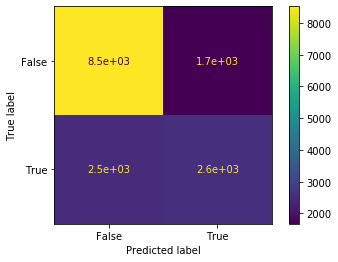

In [31]:
plot_confusion_matrix(estimator = pipeline,
                      X = test_data,
                      y_true = test_data.ContrabandIndicator)